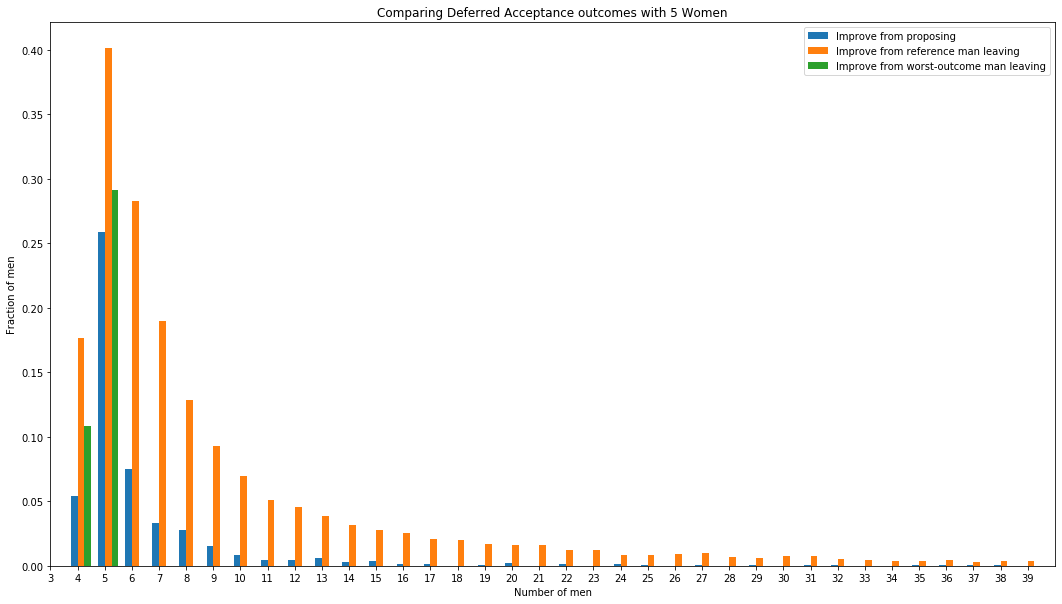

--- 14.686264991760254 seconds ---


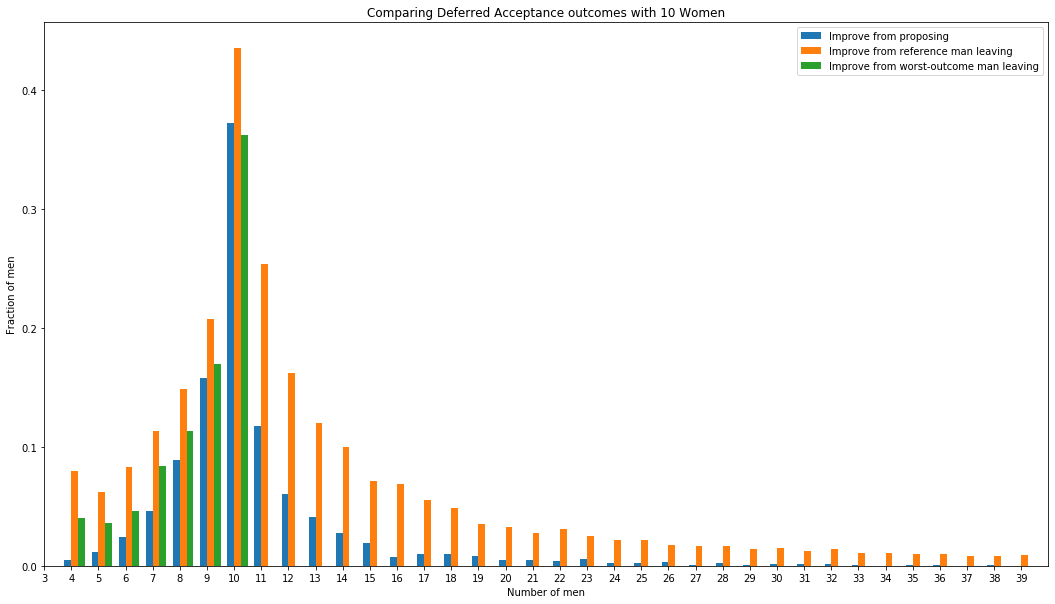

--- 42.47613716125488 seconds ---


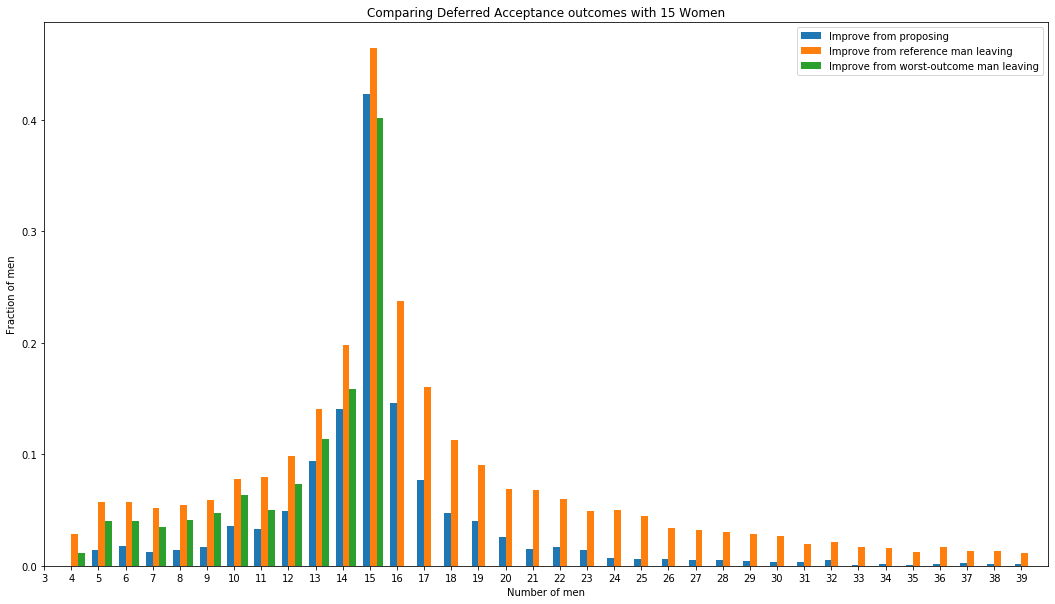

--- 88.45126104354858 seconds ---


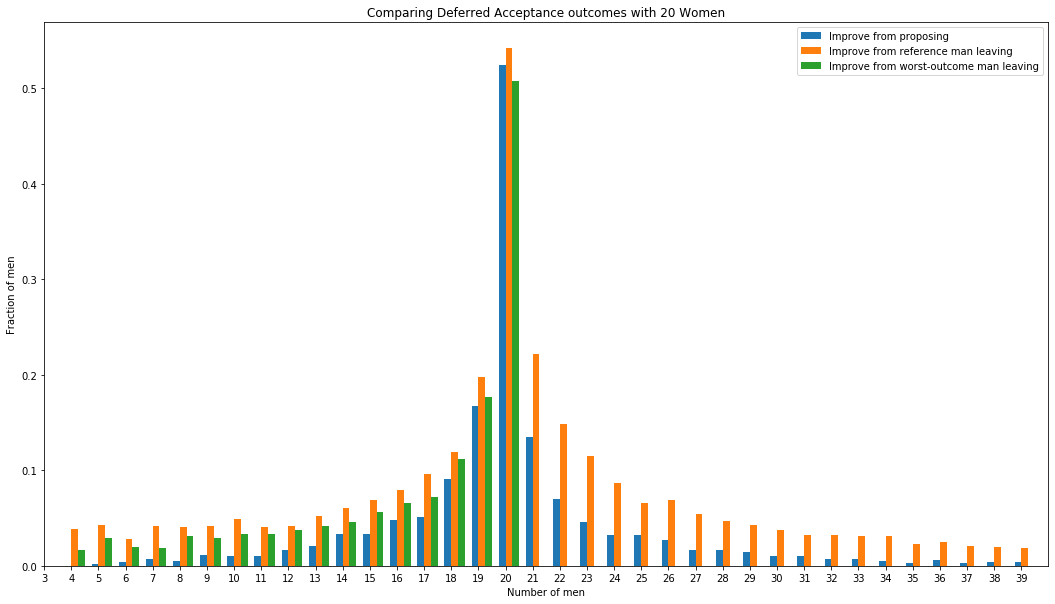

--- 155.78364992141724 seconds ---


In [2]:
import random
import copy
from pandas import *
from matplotlib import pyplot as plt
from operator import itemgetter
import numpy as np
import time

start_time = time.time()

def deferred_acceptance(proposing, not_proposing):
    
    women_temp_max_choices = [-1 for i in range(len(not_proposing))]
    
    iters = 0
    markers = [1 for i in range(len(not_proposing))] 
    # algorithm ends if the last len(not_proposing) rounds did not produce a change in matches

    '''
    Algorithm ends if there are no changes over [number of non-proposing side] rounds.
    '''
    while 1 in markers:
        matches = {}

        for i in range(len(not_proposing)):
            matches[i] = []        
        markers[(iters - len(not_proposing))%len(not_proposing)] = 0
        
        men_temp_max_choices = [-1 for i in range(len(proposing))]
        
        '''
        'matches' dictionary contains all proposers' preferred choices. 
        '''
        for i in range(len(proposing)):
            temp_max_value = 0
            for j in range(len(proposing[0])):
                if proposing[i][j] > temp_max_value:
                    temp_max_value = proposing[i][j]
                    men_temp_max_choices[i] = j
            if men_temp_max_choices[i]!=-1:
                matches[men_temp_max_choices[i]].append(i)
                
        '''
        'women_temp_max_choices' contains each woman's favorite of the men who propose to her.
        '''               
        for key, value in matches.items():
            if women_temp_max_choices[key] != -1:
                temp_value = not_proposing[key][women_temp_max_choices[key]]
            else:
                temp_value = 0
            for i in range(len(value)):
                if not_proposing[key][value[i]] == temp_value:
                    continue
                elif not_proposing[key][value[i]] > temp_value: 
                    markers[(iters - len(not_proposing))%len(not_proposing)] = 1
                    if women_temp_max_choices[key] != -1:
                        proposing[women_temp_max_choices[key]][key] = 0
                    women_temp_max_choices[key] = value[i]
                    temp_value = not_proposing[key][value[i]]
                else:
                    proposing[value[i]][key] = 0
        iters+=1
    
#     print(f"{iters} Iterations")
    return women_temp_max_choices

def compare_matches(new, old, compare_men_values):
    counter = 0
    for i in range(len(compare_men_values)): 
        if new[i] == None:
            continue
        if old[i] == -1 and new[i] != -1:
            counter+=1
        elif compare_men_values[i][new[i]] > compare_men_values[i][old[i]]:
            counter+=1
        elif compare_men_values[i][new[i]] < compare_men_values[i][old[i]]:
            print("This should never be reached")
    return counter

def remove_person(awpda_men_values, awpda_women_values, wpda_matches):
    if -1 in wpda_matches:
        worst_index = wpda_matches.index(-1)
    else:
        min_value = 1
        for i in range(len(wpda_matches)):
            if awpda_men_values[i][wpda_matches[i]] < min_value:
                worst_index = i
                min_value = awpda_men_values[i][wpda_matches[i]]
    del awpda_men_values[worst_index]
    awpda_women_values =  remove_col(awpda_women_values, worst_index)
    
    return awpda_men_values, awpda_women_values, worst_index

def remove_col(arr, ith):
    itg = itemgetter(*filter((ith).__ne__, range(len(arr[0]))))
    return list(map(list, map(itg, arr)))
    
def main():

    for i in range(5,25,5):
        max_men = 40
        proposing_difference = [0 for j in range(max_men)]
        subtraction_reference_difference = [0 for j in range(max_men)]
        subtraction_worst_difference = [0 for j in range(max_men)]
        for j in range(4,max_men):
            iters= 0
            proposing_counter = 0
            substraction_counter = 0
            while iters < 200:
                '''
                Ensure no data loss from the deferred acceptance algorithm.
                '''
                men_values = [[random.uniform(0,1) for size in range(i)] for _size in range(j)]
                women_values = [[random.uniform(0,1) for size in range(j)] for _size in range(i)]
                
                mpda_women_values = copy.deepcopy(women_values)
                mpda_men_values = copy.deepcopy(men_values)

                temp_reference_awpda_women_values = copy.deepcopy(women_values)
                reference_awpda_men_values = copy.deepcopy(men_values)
                
                temp_worst_awpda_women_values = copy.deepcopy(women_values)
                temp_worst_awpda_men_values = copy.deepcopy(men_values)
                
                compare_men_values = copy.deepcopy(men_values) # the control for comparisons
                
                '''
                Return matches from each algorithm.
                '''
                # WPDA
                wpda_matches = deferred_acceptance(women_values, men_values)
                
                # MPDA
                mpda_matches = deferred_acceptance(mpda_men_values, mpda_women_values)
                # used to put matching in men-indexed [woman, woman, ...] format
                B = [-1 for s in range(len(men_values))]  
                for index, element in enumerate(mpda_matches):
                    if element != -1:
                        B[element] = index
                mpda_matches = B
                
                # WPDA, worst man leaves
                worst_awpda_men_values, worst_awpda_women_values, worst_index = remove_person(temp_worst_awpda_men_values, temp_worst_awpda_women_values, wpda_matches)
                worst_awpda_matches = deferred_acceptance(worst_awpda_women_values, worst_awpda_men_values)
                worst_awpda_matches.insert(worst_index, None)

                # WPDA, reference man leaves
                del reference_awpda_men_values[0]
                reference_awpda_women_values =  remove_col(temp_reference_awpda_women_values, 0)
                reference_awpda_matches = deferred_acceptance(reference_awpda_women_values, reference_awpda_men_values)
                reference_awpda_matches.insert(0, None)

                '''
                Establish percentage gains from each change.
                '''
                proposing_difference[j] += compare_matches(mpda_matches, wpda_matches, compare_men_values) / len(mpda_matches)
                subtraction_reference_difference[j] += compare_matches(reference_awpda_matches, wpda_matches, compare_men_values) / (len(mpda_matches) - 1)
                subtraction_worst_difference[j] += compare_matches(worst_awpda_matches, wpda_matches, compare_men_values) / (len(mpda_matches) - 1)

                iters+=1
        '''
        Average the percentages across iterations.
        '''        
        for j in range(len(proposing_difference)):
            proposing_difference[j] /= iters
            subtraction_reference_difference[j] /= iters
            subtraction_worst_difference[j] /= iters
        
        ind = np.arange(len(proposing_difference)) # the x locations for the groups
        width = np.min(np.diff(ind))/4
        plt.figure(figsize=(18,10))
        plt.bar(ind - width, proposing_difference , width, label='Improve from proposing', align='edge')
        plt.bar(ind, subtraction_reference_difference, width, label='Improve from reference man leaving', align='edge')
        plt.bar(ind + width, subtraction_worst_difference, width, label='Improve from worst-outcome man leaving', align='edge')
        plt.xlabel('Number of men')
        plt.ylabel('Fraction of men')
        plt.title(f'Comparing Deferred Acceptance outcomes with {i} Women')
        plt.xticks(np.arange(3, 40))
        plt.xlim(3,40)
        plt.legend(loc='best')
        plt.show()
        print("--- %s seconds ---" % (time.time() - start_time))

main()    